In [1]:
import pandas as pd
import numpy as np
import torch.nn as nn
import sklearn
#from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
pd.set_option('display.max_columns', None)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import multiprocessing
import scipy
from sklearn.model_selection import KFold

# 读取数据

In [2]:
x_data = pd.read_excel("Shenyan_S82_ESPdescriptor+汪老师提取的所有特征-不含FE.xlsx")
x_data

,c1nc[nH]n1,c1c[nH]cn1,c1cc[nH]c1,c1ccncc1,c1ccc2[nH]ccc2c1,c1ccc2scnc2c1,c1ccc2cc3ccccc3cc2c1,c1cscn1,c1ccsc1,c1cn[nH]c1,c1ccc2occcc2c1,c1cc2ccc(ccnccc3ccc(ccn1)[nH]3)[nH]2,c1ccccc1,c1nnn[nH]1,c1ccc2sc[n+]c2c1,c1ccc2ncccc2c1,c1nncs1,Alkene,Alkylchloride,Alkylfluoride,Alkylbromide,Trifluoromethyl,Alcohol,Althoxyl,Primary_aliph_amine,Secondary_aliph_amine,Tertiary_aliph_amine,Primary_arom_amine,Secondary_arom_amine,Tertiary_arom_amine,Alkylthiol,Dialkylthioether,Disulfide,Aldehyde,Ketone,Oxime,Acetal,Hemiacetal,Thioacetal,Chloroalkene,Bromoalkene,Enol,Carboxylic_acid,Carboxylic_ester,Lactone,Amide,Lactam,Nitrile,Thiourea,Phenol,Arylchloride,Arylfluoride,Arylbromide,Aryliodide,Arylthiol,Oxoarene,Azo,Nitro,Sulfon,Sulfonic_derivative,Phosphonic_acid_derivative,Tri_boron,Sugar_pattern_combi,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,TPSA,EState_VSA1,EState_VSA10,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,Num of Conju-Strut,Num of Conju-All-Atoms,Atom Num Conju-All Ratio,AtomWt Conju-All Ratio,Full-Mol Wiener Index,Individual Conju-Atom Number (Max-Conju),Conju-Part-Wt (Max-Conju),Conju-AtomicWt (Max-Conju),Max Conju-Distance (Max-Conju),Conju-Branch Index (Max-Conju),Conju-Strut Wiener Index (Max-Conju),Atom_PEOE-Charge_Sum,Atom_LogP_Sum,Atom_MR_Sum,Atom_PEOE-Charge_Mean,Atom_LogP_Mean,Atom_MR_Mean,Atom_PEOE-Charge_Std,Atom_LogP_Std,Atom_MR_Std,Atom_PEOE-Charge_Max,Atom_LogP_Max,Atom_MR_Max,Atom_PEOE-Charge_Min,Atom_LogP_Min,Atom_MR_Min,Atom_PEOE-Charge_Delta,Atom_LogP_Delta,Atom_MR_Delta,Fun_PEOE-Charge_Sum,Fun_LogP_Sum,Fun_MR_Sum,Fun_PEOE-Charge_Mean,Fun_LogP_Mean,Fun_MR_Mean,Fun_PEOE-Charge_Std,Fun_LogP_Std,Fun_MR_Std,Fun_PEOE-Charge_Max,Fun_LogP_Max,Fun_MR_Max,Fun_PEOE-Charge_Min,Fun_LogP_Min,Fun_MR_Min,Fun_PEOE-Charge_Delta,Fun_LogP_Delta,Fun_MR_Delta,Mid-Fun_PEOE-Charge_Sum,Mid-Fun_LogP_Sum,Mid-Fun_MR_Sum,Mid-Fun_PEOE-Charge_Mean,Mid-Fun_LogP_Mean,Mid-Fun_MR_Mean,Mid-Fun_PEOE-Charge_Std,Mid-Fun_LogP_Std,Mid-Fun_MR_Std,Mid-Fun_PEOE-Charge_Max,Mid-Fun_LogP_Max,Mid-Fun_MR_Max,Mid-Fun_PEOE-Charge_Min,Mid-Fun_LogP_Min,Mid-Fun_MR_Min,Mid-Fun_PEOE-Charge_Delta,Mid-Fun_LogP_Delta,Mid-Fun_MR_Delta,Conju_PEOE-Charge_Sum,Conju_LogP_Sum,Conju_MR_Sum,Conju_PEOE-Charge_Mean,Conju_LogP_Mean,Conju_MR_Mean,Conju_PEOE-Charge_Std,Conju_LogP_Std,Conju_MR_Std,Conju_PEOE-Charge_Max,Conju_LogP_Max,Conju_MR_Max,Conju_PEOE-Charge_Min,Conju_LogP_Min,Conju_MR_Min,Conju_PEOE-Charge_Delta,Conju_LogP_Delta,Conju_MR_Delta,Atom Number,Occupied Orbitals,Molecule Weight,HOMO,LUMO,HOMO-LUMO Gap,Farthest Distance,Molecular Radius,Molecular Size Short,Molecular Size Medium,Molecular Size Long,Long/Sum Size Ratio,Length/Diameter,MPP,SDP,Dipole Moment (a.u.),Quadrupole Moment,Octopole Moment,ODI LUMO+1,ODI LUMO,ODI HOMO,ODI HOMO-1,ODI Mean,ODI Std,Isosurface area,Sphericity,Volume (Angstrom^3),Density (g/cm^3),LEAE Minimal Value,LEAE Maximal Value,Surfac

In [3]:
y_data = pd.read_csv("Target.csv", usecols=[8])
y_data

,FE C2+
0,27.434036
1,43.428453
2,30.042985
3,46.791230
4,44.924853
...,...
77,51.374707
78,61.745484
79,56.173029
80,43.799887


In [4]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
x_data.columns = [regex.sub("_", col) if any(i in str(col) for i in set(('[', ']', '<'))) 
                        else col for col in x_data.columns.values]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, random_state=0)

In [5]:
scaler1 = preprocessing.MinMaxScaler().fit(x_train)  # 通过训练集获得归一化函数模型，使用 x_train 数据来计算缩放器需要的最小值和最大值
scaler2 = preprocessing.MinMaxScaler().fit(y_train)

x_train = scaler1.transform(x_train)#使用拟合好的缩放器对 x_train 数据进行缩放
x_test = scaler1.transform(x_test)

y_train = scaler2.transform(y_train)
y_test = scaler2.transform(y_test)

In [6]:
num_cores = multiprocessing.cpu_count()

In [ ]:
kf = KFold(n_splits=10, random_state=0, shuffle=True) # 5折交叉验证
#mse它测量的是预测值与实际值之间差值的平方的平均值。均方误差越小，模型的预测性能越好
variate=list(range(x_train.shape[1]))   #变量索引列表
selected=[]   #变量索引
train_mse_list = []
val_mse_list = []

current_score,best_new_score=float('inf'),float('inf')  
#验证集目前的分数和最好分数初始值都为无穷大（因为mse越小越好）
    
# def my_custom_loss_func(y, y_predict):
#     error = 0
#     for i in range(0, y.shape[1]):
#         error += mean_squared_error(y[:, i], y_predict[:, i])
#     error = error / y.shape[1]
#     return error

# my_scorer = make_scorer(my_custom_loss_func, greater_is_better=False)

#循环筛选变量
while variate:
    mse_with_variate_train = []
    mse_with_variate_val=[]
    for i in variate:  #逐个遍历自变量
        current_variate = selected+[i]   #当前变量
        current_x_train = x_train[:, current_variate]   #当前x_train
        current_x_test = x_test[:, current_variate]   #当前x_test
        
        train_mse_list_ = []
        val_mse_list_ = []
        
        for train_index, val_index in kf.split(current_x_train, y_train):
            x_train_ = current_x_train[train_index, :]
            x_val_ = current_x_train[val_index, :]
            y_train_ = y_train[train_index, :]
            y_val_ = y_train[val_index, :]
            
            #model = MLPRegressor(random_state=0,early_stopping=True,alpha=0.0001,hidden_layer_sizes=(1,),learning_rate_init=0.01,
            #                    max_iter=5000,n_iter_no_change=100)
            svr = SVR(kernel='rbf')
            multioutput_svr = MultiOutputRegressor(svr, n_jobs=-1)
            multioutput_svr.fit(x_train_, y_train_)
        
            train_pre = multioutput_svr.predict(x_train_)
            val_pre = multioutput_svr.predict(x_val_)
            
            train_mse_ = mean_squared_error(y_train_, train_pre)
    
            val_mse_ = mean_squared_error(y_val_, val_pre)
    
            train_mse_list_.append(train_mse_)
    
            val_mse_list_.append(val_mse_)
            
        train_mse = np.mean(train_mse_list_)
        
        val_mse = np.mean(val_mse_list_)
        
        mse_with_variate_train.append((train_mse,i))
        
        mse_with_variate_val.append((val_mse,i))
            
    min_mse_index = mse_with_variate_val.index(min(mse_with_variate_val))
    best_new_score,best_candidate_index = mse_with_variate_val[min_mse_index]
    train_new_score,_ = mse_with_variate_train[min_mse_index]
        
    variate.remove(best_candidate_index)  #移除加进来的变量名，即第二次循环时，不考虑此自变量了
    selected.append(best_candidate_index)  #将此自变量作为加进模型中的自变量
    
    train_mse_list.append(mse_with_variate_train[min_mse_index][0])
    
    val_mse_list.append(mse_with_variate_val[min_mse_index][0])
        
        #if current_score>best_new_score:
            #variate.remove(best_candidate_index)  #移除加进来的变量名，即第二次循环时，不考虑此自变量了
            #selected.append(best_candidate_index)  #将此自变量作为加进模型中的自变量
            #current_score = best_new_score  #最新的分数等于最好的分数
            #print("score is {},continuing!".format(current_score))  #输出最小的mse值
        #else:
            #print("for selection over!")
            #break

In [33]:
selected

[175,
 146,
 200,
 170,
 243,
 199,
 130,
 116,
 244,
 97,
 165,
 236,
 269,
 147,
 247,
 118,
 99,
 167,
 232,
 50,
 63,
 155,
 264,
 238,
 131,
 162,
 126,
 73,
 28,
 211,
 38,
 135,
 304,
 125,
 233,
 134,
 58,
 255,
 27,
 17,
 14,
 57,
 10,
 44,
 258,
 55,
 249,
 8,
 240,
 98,
 180,
 0,
 1,
 2,
 4,
 6,
 29,
 9,
 11,
 262,
 303,
 113,
 153,
 13,
 19,
 45,
 59,
 15,
 16,
 18,
 20,
 26,
 33,
 35,
 36,
 37,
 39,
 40,
 127,
 195,
 223,
 163,
 41,
 43,
 47,
 53,
 25,
 56,
 60,
 62,
 110,
 183,
 21,
 259,
 46,
 91,
 5,
 234,
 215,
 237,
 114,
 34,
 124,
 242,
 251,
 160,
 139,
 198,
 164,
 246,
 121,
 108,
 158,
 75,
 241,
 250,
 169,
 291,
 154,
 217,
 284,
 122,
 201,
 61,
 76,
 218,
 148,
 295,
 189,
 144,
 224,
 235,
 273,
 102,
 22,
 192,
 23,
 256,
 206,
 72,
 174,
 161,
 66,
 152,
 190,
 176,
 111,
 54,
 101,
 212,
 298,
 128,
 52,
 197,
 123,
 89,
 133,
 3,
 202,
 145,
 115,
 129,
 166,
 279,
 297,
 141,
 191,
 103,
 94,
 142,
 109,
 87,
 193,
 226,
 196,
 203,
 209,
 299,
 268,
 

In [34]:
train_mse_list

[0.02721052816338876,
 0.02025775958830493,
 0.01632855332715437,
 0.016930809682327262,
 0.015928759076246392,
 0.015149768254495374,
 0.015189255734187956,
 0.013100209919337557,
 0.012688047986928469,
 0.01250680469605559,
 0.012303437153228736,
 0.012779610663703752,
 0.01213758945750434,
 0.011932492727818166,
 0.011791152387002214,
 0.012017613892741068,
 0.012041788568066035,
 0.011720092470062365,
 0.011706861825179018,
 0.01157801136121152,
 0.01125573847351855,
 0.011337091586009625,
 0.010921269316108463,
 0.010907297334100926,
 0.010839575819841813,
 0.010707099054060356,
 0.010891475972346113,
 0.009767258719740997,
 0.009704752520596336,
 0.00950963131426524,
 0.009573323419614265,
 0.008419467026509642,
 0.008204957839653363,
 0.008170412728822345,
 0.007828403375833327,
 0.007856895230207718,
 0.007938393007229028,
 0.007862404381544575,
 0.00791679278952025,
 0.007907592898859731,
 0.007921268881433628,
 0.007948796873616059,
 0.007984804421730373,
 0.00800706086154376

In [35]:
val_mse_list

[0.02930192870614935,
 0.026417882143493575,
 0.02477570653178357,
 0.02509316841674699,
 0.025585188794483554,
 0.024754498916104956,
 0.024264396205021615,
 0.023343405510959214,
 0.0224630082889783,
 0.02155530217703498,
 0.02089433818758498,
 0.02040562385218294,
 0.02022071252540465,
 0.019895423604632215,
 0.019688456075967215,
 0.019314393444685076,
 0.019144178749945538,
 0.019175252194823272,
 0.018983218509006916,
 0.018801900685512428,
 0.01870316489606196,
 0.018638657331538185,
 0.018543500551403476,
 0.01846732623026469,
 0.018434298407376096,
 0.01823019984442715,
 0.018117794056653164,
 0.01804835371783006,
 0.017892584837862813,
 0.017717316999921205,
 0.017688725008086305,
 0.017576949555708897,
 0.017449840117666017,
 0.017387526758295746,
 0.01698006344194148,
 0.01686245136512836,
 0.016781001368782873,
 0.016518849631178202,
 0.01640774776739787,
 0.016329439328125528,
 0.01628350550485769,
 0.01625544133232517,
 0.016237210037841242,
 0.01622142017139529,
 0.0162

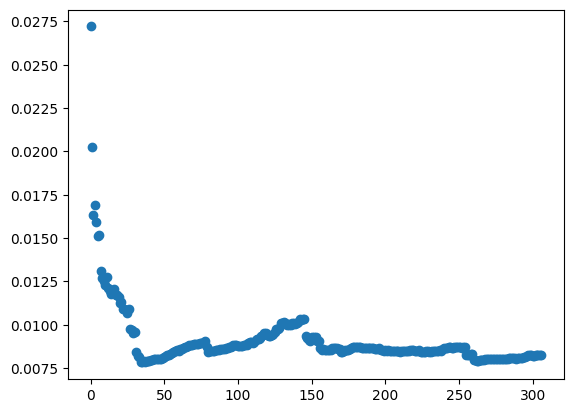

In [36]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

plt.scatter(range(len(train_mse_list)), train_mse_list)
plt.show()

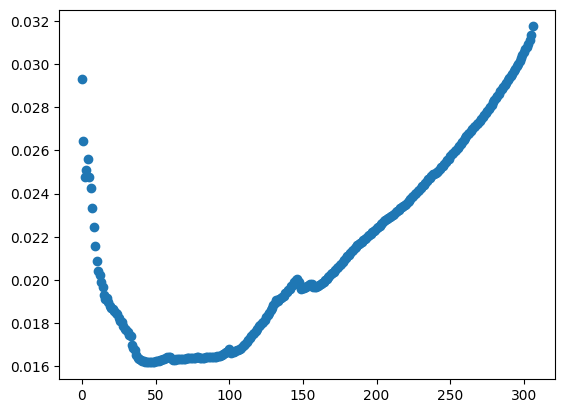

In [37]:
plt.scatter(range(len(val_mse_list)), val_mse_list)
plt.show()

In [7]:
val_mse_list = [0.02930192870614935,
 0.026417882143493575,
 0.02477570653178357,
 0.02509316841674699,
 0.025585188794483554,
 0.024754498916104956,
 0.024264396205021615,
 0.023343405510959214,
 0.0224630082889783,
 0.02155530217703498,
 0.02089433818758498,
 0.02040562385218294,
 0.02022071252540465,
 0.019895423604632215,
 0.019688456075967215,
 0.019314393444685076,
 0.019144178749945538,
 0.019175252194823272,
 0.018983218509006916,
 0.018801900685512428,
 0.01870316489606196,
 0.018638657331538185,
 0.018543500551403476,
 0.01846732623026469,
 0.018434298407376096,
 0.01823019984442715,
 0.018117794056653164,
 0.01804835371783006,
 0.017892584837862813,
 0.017717316999921205,
 0.017688725008086305,
 0.017576949555708897,
 0.017449840117666017,
 0.017387526758295746,
 0.01698006344194148,
 0.01686245136512836,
 0.016781001368782873,
 0.016518849631178202,
 0.01640774776739787,
 0.016329439328125528,
 0.01628350550485769,
 0.01625544133232517,
 0.016237210037841242,
 0.01622142017139529,
 0.016210718974341932,
 0.016194035657159243,
 0.016191351634935618,
 0.016183939543301027,
 0.016183386482159116,
 0.016207894568794946,
 0.016234043128230968,
 0.016245000171642703,
 0.016267409331396344,
 0.01629789671026653,
 0.016310628528370542,
 0.01634112235269335,
 0.016364054838997295,
 0.01639951654625515,
 0.016414952721307448,
 0.016432117555076932,
 0.016438654603179826,
 0.01632561488350573,
 0.016316572895745972,
 0.01631506284979338,
 0.016323308545137756,
 0.01632459805791039,
 0.016330440121714647,
 0.016349188247598092,
 0.016350675710460012,
 0.016346881821681845,
 0.016365784803070584,
 0.016372732821636073,
 0.016378833496314582,
 0.016380386159815824,
 0.016392743408139725,
 0.01640713540490363,
 0.016403841819454947,
 0.01641064199548444,
 0.016422302908195553,
 0.01641424618518105,
 0.01640956720801497,
 0.016402421595539604,
 0.016404396094563782,
 0.01641016953298611,
 0.016415959526876443,
 0.01642097634813792,
 0.016425480736407864,
 0.016433502493156164,
 0.016435642268622108,
 0.016430709915903806,
 0.01644314611325741,
 0.016447843675323003,
 0.01646061548552278,
 0.016482911795685055,
 0.016496140171414465,
 0.01652937401674876,
 0.016565190494470472,
 0.016622850823224324,
 0.0166689895726859,
 0.01673413988871697,
 0.016790597280786447,
 0.016642908411269454,
 0.016661265203595614,
 0.016680638100061675,
 0.016710522740430535,
 0.016738245869651388,
 0.016775367991809943,
 0.016796016060590353,
 0.01685114278358441,
 0.016927266598485508,
 0.016987086071746878,
 0.01705786578637779,
 0.01713197483520112,
 0.01721944147689935,
 0.01731096000862701,
 0.017406743365229207,
 0.017495409331058896,
 0.017537215848370986,
 0.01764331869948644,
 0.017748488923958274,
 0.017866093134554367,
 0.017934749383407368,
 0.017997460310719724,
 0.01806126776977506,
 0.018161328883855438,
 0.018269999778891537,
 0.018390433007285996,
 0.018491075038147477,
 0.01861855923699101,
 0.018720203425405545,
 0.018842009487914917,
 0.01895358628972527,
 0.019063864502605138,
 0.019032880917933936,
 0.019106801371302808,
 0.01918005458019488,
 0.01922226862271461,
 0.01928358599000794,
 0.019381275653380506,
 0.019447125860348774,
 0.019517843171090326,
 0.019603675885285863,
 0.01970646154213844,
 0.019781193817905655,
 0.01989199124757788,
 0.020002189632290012,
 0.020034429489717464,
 0.01990389636544883,
 0.019762832250825556,
 0.019581049551212548,
 0.01960960596989526,
 0.019646715512744845,
 0.019681119141779457,
 0.019729222675064148,
 0.019783824568195087,
 0.01979731910610605,
 0.01979374848750972,
 0.019676091413415964,
 0.019690393288184595,
 0.019693207690843442,
 0.01971205918267156,
 0.01974723000401531,
 0.019794099253323132,
 0.019858068908331368,
 0.019926499743062993,
 0.019990205281258284,
 0.020059706012172468,
 0.020117708706829166,
 0.020193218860422642,
 0.020265581553219347,
 0.02032664982745735,
 0.02038962259168034,
 0.02046842756023844,
 0.020535940834190684,
 0.020613660515865957,
 0.02068706658650293,
 0.020763997116370937,
 0.020844228170137653,
 0.020918215332202634,
 0.02100197059753507,
 0.02109163152257474,
 0.02117601106457722,
 0.021264153831677263,
 0.021342587571729788,
 0.021410701425494623,
 0.021482151949165283,
 0.021547159001726223,
 0.021615317737752347,
 0.021666864649647642,
 0.02172307573454844,
 0.02177847307521026,
 0.02183448388466752,
 0.02190747533212519,
 0.021965219373315262,
 0.022024264644521077,
 0.022078671710998157,
 0.02214353834661667,
 0.022203139817034423,
 0.022265373114430467,
 0.022335101677237023,
 0.02238914463447015,
 0.02245559668252564,
 0.022520900022677457,
 0.022586632652285433,
 0.022660348633126007,
 0.02271988427580975,
 0.02277138794085027,
 0.022812335690676297,
 0.022859209189530653,
 0.02291538161907567,
 0.022958179354705142,
 0.023008270451352848,
 0.02308051674396882,
 0.02313598170887869,
 0.023197721457642248,
 0.023248151576036123,
 0.023314482862951645,
 0.023375848804265173,
 0.023430221709898814,
 0.023486689368211897,
 0.023541845627698975,
 0.023602552811890533,
 0.023672953352107815,
 0.023743472597142202,
 0.02382631318324547,
 0.02389190879170209,
 0.02396183847670224,
 0.024030922582089446,
 0.024104631844396866,
 0.024172657975162944,
 0.024260370347614184,
 0.02434353622395597,
 0.024413865244822593,
 0.024495280085576478,
 0.024572705868152342,
 0.024655527339998113,
 0.02473776452659874,
 0.024810850082480226,
 0.02490320104195521,
 0.024902725879164825,
 0.024947669824247707,
 0.024994858857186043,
 0.025055765172283723,
 0.02513981386590395,
 0.025222292963019206,
 0.02529770154942143,
 0.025380616615809547,
 0.025464069120674872,
 0.02554185363142277,
 0.02562333233560283,
 0.025719539038520388,
 0.025814312877116507,
 0.025887317421096446,
 0.025972129375081154,
 0.026042211248162132,
 0.026127129240710013,
 0.02622197410403812,
 0.02630129732282151,
 0.026380567569123027,
 0.02647798853893803,
 0.02656018918690887,
 0.026660034330775028,
 0.02674456015193479,
 0.026819787030101256,
 0.026910750185737735,
 0.026985653664359965,
 0.027070536701722,
 0.027137816356256818,
 0.027210284924913574,
 0.027293448530027353,
 0.027376422924154976,
 0.027462645712266413,
 0.027537827849744484,
 0.027627635082844982,
 0.027728265629857436,
 0.027817733329229977,
 0.027905469305662473,
 0.028025776260647606,
 0.02811716866794703,
 0.028227182616521174,
 0.028329530249052676,
 0.028427162519542377,
 0.02852365248690189,
 0.02862942716531518,
 0.02873865481507996,
 0.02884348225912365,
 0.028927911673913405,
 0.029034060219260367,
 0.029140735878682357,
 0.029242478032887494,
 0.029350437425359543,
 0.029452270757050186,
 0.029555713198409293,
 0.0296674746951635,
 0.029791783534539224,
 0.02989905240017286,
 0.030019538995723828,
 0.030150097403351023,
 0.030292998166758234,
 0.03041716285076318,
 0.030540583448849867,
 0.03067593820642108,
 0.030792261075708104,
 0.03094357946033368,
 0.031112345126442436,
 0.031356269586052934,
 0.03173902903748321]

min_index  = val_mse_list.index(min(val_mse_list))
min_value = val_mse_list[min_index]
print(min_index)
print(min_value)

48
0.016183386482159116


In [8]:
selected = [175,
 146,
 200,
 170,
 243,
 199,
 130,
 116,
 244,
 97,
 165,
 236,
 269,
 147,
 247,
 118,
 99,
 167,
 232,
 50,
 63,
 155,
 264,
 238,
 131,
 162,
 126,
 73,
 28,
 211,
 38,
 135,
 304,
 125,
 233,
 134,
 58,
 255,
 27,
 17,
 14,
 57,
 10,
 44,
 258,
 55,
 249,
 8,
 240,
 98,
 180,
 0,
 1,
 2,
 4,
 6,
 29,
 9,
 11,
 262,
 303,
 113,
 153,
 13,
 19,
 45,
 59,
 15,
 16,
 18,
 20,
 26,
 33,
 35,
 36,
 37,
 39,
 40,
 127,
 195,
 223,
 163,
 41,
 43,
 47,
 53,
 25,
 56,
 60,
 62,
 110,
 183,
 21,
 259,
 46,
 91,
 5,
 234,
 215,
 237,
 114,
 34,
 124,
 242,
 251,
 160,
 139,
 198,
 164,
 246,
 121,
 108,
 158,
 75,
 241,
 250,
 169,
 291,
 154,
 217,
 284,
 122,
 201,
 61,
 76,
 218,
 148,
 295,
 189,
 144,
 224,
 235,
 273,
 102,
 22,
 192,
 23,
 256,
 206,
 72,
 174,
 161,
 66,
 152,
 190,
 176,
 111,
 54,
 101,
 212,
 298,
 128,
 52,
 197,
 123,
 89,
 133,
 3,
 202,
 145,
 115,
 129,
 166,
 279,
 297,
 141,
 191,
 103,
 94,
 142,
 109,
 87,
 193,
 226,
 196,
 203,
 209,
 299,
 268,
 105,
 95,
 181,
 77,
 267,
 51,
 150,
 80,
 271,
 138,
 70,
 68,
 81,
 69,
 85,
 78,
 67,
 254,
 270,
 93,
 65,
 90,
 42,
 253,
 221,
 104,
 252,
 83,
 278,
 282,
 276,
 137,
 100,
 82,
 79,
 168,
 293,
 257,
 182,
 229,
 220,
 86,
 136,
 277,
 84,
 132,
 159,
 216,
 227,
 261,
 305,
 96,
 230,
 184,
 177,
 88,
 64,
 306,
 173,
 283,
 281,
 194,
 288,
 280,
 274,
 300,
 228,
 302,
 272,
 117,
 185,
 260,
 151,
 186,
 187,
 301,
 49,
 188,
 290,
 210,
 275,
 119,
 245,
 30,
 239,
 248,
 289,
 143,
 286,
 179,
 71,
 92,
 74,
 294,
 7,
 231,
 214,
 208,
 296,
 222,
 225,
 205,
 219,
 207,
 107,
 24,
 172,
 48,
 263,
 266,
 265,
 32,
 213,
 31,
 112,
 204,
 171,
 149,
 292,
 120,
 140,
 157,
 156,
 12,
 285,
 106,
 287,
 178]

#for i in selected[:18]:
    #j = sorted_index[i]
    #print('{}'.format(x_train.columns[j]))

In [9]:
selected_columns = x_data.columns[selected[:min_index+1]].tolist()
for col in selected_columns:
    print(col)

Conju-Part-Wt (Max-Conju)
VSA_EState7
Fun_MR_Sum
Num of Conju-All-Atoms
Conju_PEOE-Charge_Max
Fun_LogP_Sum
EState_VSA10
SMR_VSA9
Conju_LogP_Max
PEOE_VSA12
NumSaturatedRings
Conju_MR_Sum
Octopole Moment
VSA_EState8
Conju_LogP_Min
SlogP_VSA10
PEOE_VSA14
MolLogP
Mid-Fun_LogP_Delta
Arylchloride
MaxAbsEStateIndex
NumAliphaticRings
Length/Diameter
Conju_LogP_Mean
EState_VSA2
NumRotatableBonds
SlogP_VSA7
MaxAbsPartialCharge
Secondary_arom_amine
Fun_LogP_Min
Thioacetal
EState_VSA6
Atom1_ALIE Min value
SlogP_VSA6
Mid-Fun_MR_Delta
EState_VSA5
Sulfon
HOMO
Primary_arom_amine
Alkene
c1ccc2sc_n+_c2c1
Nitro
c1ccc2occcc2c1
Lactone
Farthest Distance
Oxoarene
Conju_PEOE-Charge_Delta
c1ccsc1
Conju_PEOE-Charge_Std


In [41]:
#col_index = [sorted_index[i] for i in selected[:min_index+1]]
# 指定图像保存的路径
import os
save_dir = '逐步回归S-体系挑选变量\用师兄的特征 and 汪老师的特征'
os.makedirs(save_dir, exist_ok=True)  # 创建目录，如果目录不存在
data = x_data[selected_columns]
# 将选定的数据保存为 CSV 文件
output_file = os.path.join(save_dir, "selected_features-C2+.csv")
data.to_csv(output_file, index=False, encoding='utf_8_sig')
data

,Conju-Part-Wt (Max-Conju),VSA_EState7,Fun_MR_Sum,Num of Conju-All-Atoms,Conju_PEOE-Charge_Max,Fun_LogP_Sum,EState_VSA10,SMR_VSA9,Conju_LogP_Max,PEOE_VSA12,NumSaturatedRings,Conju_MR_Sum,Octopole Moment,VSA_EState8,Conju_LogP_Min,SlogP_VSA10,PEOE_VSA14,MolLogP,Mid-Fun_LogP_Delta,Arylchloride,MaxAbsEStateIndex,NumAliphaticRings,Length/Diameter,Conju_LogP_Mean,EState_VSA2,NumRotatableBonds,SlogP_VSA7,MaxAbsPartialCharge,Secondary_arom_amine,Fun_LogP_Min,Thioacetal,EState_VSA6,Atom1_ALIE Min value,SlogP_VSA6,Mid-Fun_MR_Delta,EState_VSA5,Sulfon,HOMO,Primary_arom_amine,Alkene,c1ccc2sc_n+_c2c1,Nitro,c1ccc2occcc2c1,Lactone,Farthest Distance,Oxoarene,Conju_PEOE-Charge_Delta,c1ccsc1,Conju_PEOE-Charge_Std
0,108.121,0.000000,34.0375,7,-1.259678e-01,0.2314,4.794537,0.0,0.6122,0.0,0,28.2835,141.3395,1.443818,0.6122,0.0,7.118392,-0.3695,0.3808,0,10.728455,0,0.969130,0.6122,5.783245,2,0.0,0.498582,0,-0.3808,0,6.066367,9.858382,12.132734,5.7540,12.990104,0,-0.256346,0,0,0,0,0,0,8.294,0,0.000000e+00,1,0.000000e+00
1,160.015,0.000000,32.0190,6,-4.160000e-17,2.5106,0.000000,0.0,2.5106,0.0,0,32.0190,49.2643,0.000000,2.5106,0.0,0.000000,2.5106,0.0000,0,3.299769,0,0.996192,2.5106,0.000000,0,0.0,0.136847,0,0.8456,0,11.336786,9.734129,21.299212,0.0000,3.786415,0,-0.237867,0,0,0,0,0,0,5.355,0,0.000000e+00,1,0.000000e+00
2,44.009,0.000000,16.6218,3,-1.231819e-01,-0.0417,4.794537,0.0,-0.4222,0.0,0,7.6358,27.9638,0.000000,-0.4222,0.0,5.969305,0.0008,0.8027,0,9.291667,0,1.064687,-0.4222,5.752854,1,0.0,0.480630,0,-0.4222,0,0.000000,8.768344,0.000000,1.3502,0.000000,0,-0.263323,0,0,0,0,0,0,4.083,0,0.000000e+00,0,0.000000e+00
3,44.009,0.259401,30.4536,6,-1.337200e-01,0.4520,9.589074,0.0,-0.4222,0.0,0,15.2716,596.5079,0.000000,-0.4222,0.0,11.938611,1.3172,1.7186,0,10.023517,0,0.998692,-0.4222,12.841643,7,0.0,0.481208,0,-0.4222,0,0.000000,8.509234,0.000000,7.5462,21.587796,0,-0.240901,0,0,0,0,0,0,9.190,0,0.000000e+00,0,0.000000e+00
4,24.022,3.793981,20.3940,4,-1.928926e-02,1.3584,0.000000,0.0,0.6792,0.0,0,20.3940,67.3000,7.154722,0.6792,0.0,0.000000,2.0916,0.0000,0,3.577361,0,1.000000,0.6792,0.000000,4,0.0,0.153720,0,0.6792,0,0.000000,7.853093,25.309912,0.0000,0.000000,0,-0.226450,0,2,0,0,0,0,9.166,0,2.080000e-17,0,1.040000e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,0.000,10.967467,17.9720,0,0.000000e+00,0.7610,0.000000,0.0,0.0000,0.0,0,0.0000,529.6783,0.000000,0.0000,0.0,0.000000,3.9668,0.0000,0,4.183278,0,0.999512,0.0000,0.000000,9,0.0,0.179364,0,0.3805,0,0.000000,8.026730,0.000000,0.0000,51.366573,0,-0.239577,0,0,0,0,0,0,15.453,0,0.000000e+00,0,0.000000e+00
78,0.000,8.044435,17.9720,0,0.000000e+00,0.7610,0.000000,0.0,0.0000,0.0,0,0.0000,379.8979,0.000000,0.0000,0.0,0.000000,3.1866,0.0000,0,4.151822,0,0.999245,0.0000,0.000000,7,0.0,0.179364,0,0.3805,0,0.000000,8.027367,0.000000,0.0000,38.524930,0,-0.239609,0,0,0,0,0,0,12.895,0,0.000000e+00,0,0.000000e+00
79,0.000,3.764228,17.9720,0,0.000000e+00,0.7610,0.000000,0.0,0.0000,0.0,0,0.0000,185.4900,0.000000,0.0000,0.0,0.000000,2.0163,0.0000,0,4.068503,0,0.996032,0.0000,0.000000,4,0.0,0.179364,0,0.3805,0,0.000000,8.035676,0.000000,0.0000,19.262465,0,-0.239940,0,0,0,0,0,0,9.099,0,0.000000e+00,0,0.000000e+00
80,0.000,2.402006,17.9720,0,0.000000e+00,0.7610,0.000000,0.0,0.0000,0.0,0,0.0000,153.0647,0.000000,0.0000,0.0,0.000000,1.6262,0.0000,0,4.020664,0,0.995917,0.0000,0.000000,3,0.0,0.179363,0,0.3805,0,0.000000,8.049127,0.000000,0.0000,12.841643,0,-0.240430,0,0,0,0,0,0,7.776,0,0.000000e+00,0,0.000000e+00


In [10]:
from sklearn.metrics import mean_squared_error, r2_score
# 用选出来的最佳变量在测试集上进行评估
min_val_mse_index=min_index
final_x_train = x_train[:, selected[:min_val_mse_index+1]]
final_x_test = x_test[:, selected[:min_val_mse_index+1]]

svr = SVR(kernel='rbf')
multioutput_svr = MultiOutputRegressor(svr, n_jobs=-1)
multioutput_svr.fit(final_x_train, y_train)

test_pred = multioutput_svr.predict(final_x_test)
test_mse = mean_squared_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)
# 保留两位小数
test_mse = round(test_mse, 4)
test_r2 = round(test_r2, 4)

print(f"Selected variables based on validation MSE: {selected_columns}")
print(f"Test MSE: {test_mse}")
print(f"Test R2: {test_r2}")
# 创建保存目录
import os
save_dir = 'Test mse after svr'
os.makedirs(save_dir, exist_ok=True)  # 创建目录，如果目录不存在
output_file1 = os.path.join(save_dir, "final_evaluation-C2+.csv")
# 保存测试集评估结果到CSV
df_summary = pd.DataFrame({
    'Selected Variables': [selected_columns],
    'Final Test MSE': [test_mse],
    'Final Test R2': [test_r2]
})
df_summary.to_csv(output_file1, index=False)

print(f"Results saved to '{output_file1}'")

Selected variables based on validation MSE: ['Conju-Part-Wt (Max-Conju)', 'VSA_EState7', 'Fun_MR_Sum', 'Num of Conju-All-Atoms', 'Conju_PEOE-Charge_Max', 'Fun_LogP_Sum', 'EState_VSA10', 'SMR_VSA9', 'Conju_LogP_Max', 'PEOE_VSA12', 'NumSaturatedRings', 'Conju_MR_Sum', 'Octopole Moment', 'VSA_EState8', 'Conju_LogP_Min', 'SlogP_VSA10', 'PEOE_VSA14', 'MolLogP', 'Mid-Fun_LogP_Delta', 'Arylchloride', 'MaxAbsEStateIndex', 'NumAliphaticRings', 'Length/Diameter', 'Conju_LogP_Mean', 'EState_VSA2', 'NumRotatableBonds', 'SlogP_VSA7', 'MaxAbsPartialCharge', 'Secondary_arom_amine', 'Fun_LogP_Min', 'Thioacetal', 'EState_VSA6', 'Atom1_ALIE Min value', 'SlogP_VSA6', 'Mid-Fun_MR_Delta', 'EState_VSA5', 'Sulfon', 'HOMO', 'Primary_arom_amine', 'Alkene', 'c1ccc2sc_n+_c2c1', 'Nitro', 'c1ccc2occcc2c1', 'Lactone', 'Farthest Distance', 'Oxoarene', 'Conju_PEOE-Charge_Delta', 'c1ccsc1', 'Conju_PEOE-Charge_Std']
Test MSE: 0.0528
Test R2: -0.1117
Results saved to 'Test mse after svr/final_evaluation-C2+.csv'
